In [1039]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import requests
import tweepy
import sys
import json
import math
import re
from scipy import stats
%matplotlib inline

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

## Data Gathering
> As part of the data gathering step, we will be gathering data from 3 different sources:
- twitter_archive_enhanced.csv with basic tweet data for all 5000+ of their tweet
- image_predictions.tsv with predicted breed of dog for each tweet according to a neural network
- tweet_json.txt with each tweet's retweet count and favorite ("like") count


In [1040]:
# Read datafile twitter_archive_enhanced.csv
tweet_archieve = pd.read_csv("twitter-archive-enhanced.csv")
tweet_archieve.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None


In [1041]:
# Download datafile image_predictions.tsv from the online server
url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
response = requests.get(url)

# Write contents to file 
# response.content is in bytes and not text which is why we open file in wb mode
with open(url.split('/')[-1], mode = 'wb') as file:
    file.write(response.content)

In [1042]:
# Read file image-predictions.tsv and store the required columns in a dataframe
tweet_pred = pd.read_csv('image-predictions.tsv', sep='\t')
tweet_pred.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [1043]:
# To create datafile tweet_json.txt, query the Twitter API for each tweet's JSON data

consumer_key = ""
consumer_secret = ""
access_token = ""
access_token_secret = ""

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [1044]:
# Fetch tweets data from using the api and write the JSON content to the tweet_json.txt
# Public tweets are not JSON serializable so we ._json while writing to contents to outfile
tweet_list = tweet_archieve['tweet_id'].tolist()
with open('tweet_json.txt', 'a', encoding = 'utf8') as outfile:
    for tweet_id in tweet_list:
        try:
            tweet = api.get_status(tweet_id, tweet_mode = 'extended')
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except:
            continue

In [1045]:
# Read tweet_json.txt file and store the required columns in a dataframe
tweet_details = pd.DataFrame(columns = ['id_str','retweet_count','favorite_count'])
with open('tweet_json.txt') as file:
    for line in file:
        tweet = json.loads(line)
        tweet_id = tweet['id_str']
        retweet_count = tweet['retweet_count']
        favorite_count = tweet['favorite_count']
        tweet_details = tweet_details.append(pd.DataFrame([[tweet_id, retweet_count, favorite_count]], \
                                          columns=['id_str','retweet_count','favorite_count']))
tweet_json = tweet_details.reset_index(drop=True)
tweet_json.head()

,id_str,retweet_count,favorite_count
0,892420643555336193,8173,37501
1,892177421306343426,6050,32243
2,891815181378084864,4001,24286
3,891689557279858688,8317,40825
4,891327558926688256,9019,39050


## Data Assessment
> In the data assess step, we will programatically and visually assess the 3 data sources that we collected data from.
<br> <br>
Within the quality issues, we are specifically looking for completeness, valididty, accuracy, and consistency.
For the tidiness issues, we will primarily be focussing on the structure of the dataset i.e. if each variable forms a column, each observation forms a row, and each observational unit forms a table.

#### tweet_archieve

In [1046]:
# Check for unique tweets and remove reweets if any
tweet_archieve.info()
tweet_archieve.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None


In [1047]:
# Although info() shows all values are not null but we should explicitely check for None and NaNs
len(tweet_archieve[tweet_archieve['name'] == 'None'])

745

In [1048]:
# Although the info() tells all values are not null but value_counts() gives us additional information on None and NaNs
# The dog type could be pivoted to be shown under 1 column
print('**********')
print(tweet_archieve['doggo'].value_counts())
print('**********')
print(tweet_archieve['floofer'].value_counts())
print('**********')
print(tweet_archieve['pupper'].value_counts())
print('**********')
print(tweet_archieve['puppo'].value_counts())
print('**********')

**********
None     2259
doggo    97  
Name: doggo, dtype: int64
**********
None       2346
floofer    10  
Name: floofer, dtype: int64
**********
None      2099
pupper    257 
Name: pupper, dtype: int64
**********
None     2326
puppo    30  
Name: puppo, dtype: int64
**********


In [1049]:
# Check for the tweets where all 4 types are None
len(tweet_archieve[(tweet_archieve['doggo']=='None') & (tweet_archieve['floofer']=='None') &\
              (tweet_archieve['pupper']=='None') & (tweet_archieve['puppo']=='None')])

1976

In [1050]:
# 5 point summary for descriptive columns
print('**********')
print(tweet_archieve['timestamp'].describe())
print('**********')
print(tweet_archieve['rating_numerator'].describe())
print('**********')
print(tweet_archieve['rating_denominator'].describe())
print('**********')

**********
count     2356                     
unique    2356                     
top       2016-12-25 20:00:07 +0000
freq      1                        
Name: timestamp, dtype: object
**********
count    2356.000000
mean     13.126486  
std      45.876648  
min      0.000000   
25%      10.000000  
50%      11.000000  
75%      12.000000  
max      1776.000000
Name: rating_numerator, dtype: float64
**********
count    2356.000000
mean     10.455433  
std      6.745237   
min      0.000000   
25%      10.000000  
50%      10.000000  
75%      10.000000  
max      170.000000 
Name: rating_denominator, dtype: float64
**********


In [1051]:
#To see complete text for columns
pd.set_option('display.max_colwidth', -1)

In [1052]:
# 23 records that do not have a denominator 10 will need to be investigated further
len(tweet_archieve[tweet_archieve['rating_denominator']!=10])

# From visual assessment, we see rating_denominator for a lot of these records have been extracted incorrect
tweet_archieve[tweet_archieve['rating_denominator']!=10]['text']

313     @jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho                                                                       
342     @docmisterio account started on 11/15/15                                                                                                                                 
433     The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd                                                                      
516     Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx
784     RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…                             
902     Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE                        

In [1053]:
# 451 records that have a numerator either less than 10 or greater than 100 i.e. have extreme ratings
len(tweet_archieve.loc[~tweet_archieve['rating_numerator'].between(10,100)])

# numerator seems to have a very high outliers and standard deviation, needs a detailed investigation
tweet_archieve['rating_numerator'].describe()

count    2356.000000
mean     13.126486  
std      45.876648  
min      0.000000   
25%      10.000000  
50%      11.000000  
75%      12.000000  
max      1776.000000
Name: rating_numerator, dtype: float64

In [1054]:
# Check if any tweet has multiple dog stages - 14 
(tweet_archieve.loc[(tweet_archieve[['doggo', 'floofer', 'pupper', 'puppo']] != 'None').sum(axis=1) > 1])\
['tweet_id'].count()

14

What we have observed from above is we would need to dig deeper for fixing name, dog types, and numerator and denominator ratings. Since most of these are coming from 'text' column, we would need to analyse that field to fetch those again.

#### tweet_pred

In [1055]:
tweet_pred.info()
tweet_pred.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [1056]:
# Check for duplicates in twitter id - 0
sum(tweet_pred['tweet_id'].duplicated())

0

#### tweet_json

In [1057]:
tweet_json.info()
tweet_json.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3217 entries, 0 to 3216
Data columns (total 3 columns):
id_str            3217 non-null object
retweet_count     3217 non-null object
favorite_count    3217 non-null object
dtypes: object(3)
memory usage: 75.5+ KB


,id_str,retweet_count,favorite_count
0,892420643555336193,8173,37501
1,892177421306343426,6050,32243
2,891815181378084864,4001,24286
3,891689557279858688,8317,40825
4,891327558926688256,9019,39050


In [1058]:
# Check for duplicates in twitter id - 880
sum(tweet_json['id_str'].duplicated())

880

In [1059]:
# Fetch the duplicated records
dup_id = tweet_json[tweet_json['id_str'].duplicated()==True]['id_str']
tweet_json.query('id_str in @dup_id').sort_values(by='id_str').head(10)

,id_str,retweet_count,favorite_count
882,758828659922702336,4071,11656
1762,758828659922702336,4028,11608
1761,758854675097526272,935,3685
881,758854675097526272,954,3697
880,759047813560868866,2148,6762
1760,759047813560868866,2119,6748
1759,759099523532779520,4362,15081
879,759099523532779520,4428,15141
1758,759159934323924993,1223,0
878,759159934323924993,1234,0


#### List of issues found:

#### Quality checks:
- tweet_archieve: Identify and drop the retweets
- Define the columns of interest and drop the rest: <br>
  tweet_archieve: 'tweet_id', 'timestamp', 'text', 'rating_numerator', 'rating_denominator', 'name', doggo', 'floofer', 'pupper', 'puppo' <br>
  tweet_pred: 'tweet_id', 'img_num', 'p1', 'p1_conf' <br>
  tweet_json: all columns
- Check the data type of all the identified variables like: <br>
  tweet_archieve:'timestamp', 'tweet_id', 'rating_numerator', 'rating_denominator'
  tweet_pred: 'tweet_id'
  tweet_json: 'retweet_count', 'favorite_count'
- Look for errorneous records like: <br>
  tweet_archieve: 'rating_denominator', 'rating_numerator', 'dog_stage'
- Handle missing values, None, and nulls in those variables like: <br>
  tweet_archieve: 'dog_stage' with values puppo, pupper, doggo, fluffer
- Consistency in values
- Drop duplicate values like: <br>
  tweet_json: 'id_str'
- Rename columns to more meaningful names like: <br>
  tweet_pred: 'p1'->'dog_prediction',  <br>
  tweet_json:'id_str'->'tweet_id' etc.
  
#### Tidiness checks:
- Merge the extracted new fields like numerator and denominator back with original dataframe
- Create a new column 'dog_stage' by analyzing columns doggo, floofer, pupper and puppo
- Create one master table after all the 3 tables were assessed and cleaned individually

## Data Cleaning
> Under data cleaning section we will be cleaning up / removing the issues we found in the dataframe to be able to proceed with our analyses in an efficient way and get accurate and meaningful insights.

In [1060]:
# Create a copy for all 3 dataframes to apply the cleaning steps
tweet_archieve_clean = tweet_archieve.copy()
tweet_pred_clean = tweet_pred.copy()
tweet_json_clean = tweet_json.copy()

#### tweet_archieve:

In [1061]:
# Quality Issue #1
# Define: Completeness - drop the rows not required like retweets in our dataset
# Code:
tweet_archieve_clean.drop(tweet_archieve_clean.index[~pd.isnull(tweet_archieve_clean['retweeted_status_id'])], \
                          axis=0, inplace=True)
# Test:
tweet_archieve_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2175 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2175 non-null object
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null int64
rating_denominator            2175 non-null int64
name                          2175 non-null object
doggo                         2175 non-null object
floofer                       2175 non-null object
pupper                        2175 non-null object
puppo                         2175 non-null object
dtypes: float64(4), int64(3), object(1

In [1062]:
# Quality Issue #2
# Define: Completeness - drop the columns no longer required
# Code:
tweet_archieve_clean = tweet_archieve_clean.drop(['source','in_reply_to_status_id','in_reply_to_user_id',\
                                                    'retweeted_status_id','retweeted_status_user_id',\
                                                    'retweeted_status_timestamp','expanded_urls'], axis=1)
# Test:
tweet_archieve_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 10 columns):
tweet_id              2175 non-null int64
timestamp             2175 non-null object
text                  2175 non-null object
rating_numerator      2175 non-null int64
rating_denominator    2175 non-null int64
name                  2175 non-null object
doggo                 2175 non-null object
floofer               2175 non-null object
pupper                2175 non-null object
puppo                 2175 non-null object
dtypes: int64(3), object(7)
memory usage: 186.9+ KB


In [1063]:
# Quality Issue #3
# Define: Validity issue- wrong datatypes for timestamp, tweet_id, and rating
# Code:
tweet_archieve_clean['tweet_id'] = tweet_archieve_clean['tweet_id'].astype(str)
tweet_archieve_clean['timestamp'] = pd.to_datetime(tweet_archieve_clean['timestamp'])
tweet_archieve_clean['rating_denominator'] = tweet_archieve_clean['rating_denominator'].astype(float)
tweet_archieve_clean['rating_numerator'] = tweet_archieve_clean['rating_numerator'].astype(float)
# Test:
tweet_archieve_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 10 columns):
tweet_id              2175 non-null object
timestamp             2175 non-null datetime64[ns, UTC]
text                  2175 non-null object
rating_numerator      2175 non-null float64
rating_denominator    2175 non-null float64
name                  2175 non-null object
doggo                 2175 non-null object
floofer               2175 non-null object
pupper                2175 non-null object
puppo                 2175 non-null object
dtypes: datetime64[ns, UTC](1), float64(2), object(7)
memory usage: 186.9+ KB


In [1064]:
# Quality Issue #4
# Define: Consistency - rename columns to more meaningful names
# Code:
tweet_archieve_clean.rename(columns={'timestamp':'tweet_timestamp'}, inplace=True)
tweet_archieve_clean.rename(columns={'text':'tweet_detail'}, inplace=True)
tweet_archieve_clean.rename(columns={'name':'dog_name'}, inplace=True)
# Test:
tweet_archieve_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 10 columns):
tweet_id              2175 non-null object
tweet_timestamp       2175 non-null datetime64[ns, UTC]
tweet_detail          2175 non-null object
rating_numerator      2175 non-null float64
rating_denominator    2175 non-null float64
dog_name              2175 non-null object
doggo                 2175 non-null object
floofer               2175 non-null object
pupper                2175 non-null object
puppo                 2175 non-null object
dtypes: datetime64[ns, UTC](1), float64(2), object(7)
memory usage: 186.9+ KB


In [1065]:
# Quality Issue #5
# Define: Accuracy - extract the denominator where it is not extracted correctly
# Code:
temp=pd.DataFrame()
tweet_archieve_fix_denom=pd.DataFrame()
tweet_archieve_fix_denom = tweet_archieve_clean[tweet_archieve_clean['rating_denominator']!=10]   
for t_id, row in zip(tweet_archieve_fix_denom['tweet_id'],tweet_archieve_fix_denom['tweet_detail']):
    match = re.search('(..)/10', row)
    if match:
        numer = match.group(1)
        temp = temp.append(pd.DataFrame({'tweet_id':[t_id], 'rate_numer': [numer], 'rate_denom': '10'}))
tweet_archieve_fix_denom.drop_duplicates(inplace=True)
tweet_archieve_fix_denom = tweet_archieve_fix_denom.merge(temp, on='tweet_id', how='left')
# Test:
tweet_archieve_fix_denom.info()
tweet_archieve_fix_denom

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22 entries, 0 to 21
Data columns (total 12 columns):
tweet_id              22 non-null object
tweet_timestamp       22 non-null datetime64[ns, UTC]
tweet_detail          22 non-null object
rating_numerator      22 non-null float64
rating_denominator    22 non-null float64
dog_name              22 non-null object
doggo                 22 non-null object
floofer               22 non-null object
pupper                22 non-null object
puppo                 22 non-null object
rate_numer            6 non-null object
rate_denom            6 non-null object
dtypes: datetime64[ns, UTC](1), float64(2), object(9)
memory usage: 2.2+ KB


,tweet_id,tweet_timestamp,tweet_detail,rating_numerator,rating_denominator,dog_name,doggo,floofer,pupper,puppo,rate_numer,rate_denom
0,835246439529840640,2017-02-24 21:54:03+00:00,"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",960.0,0.0,None,None,None,None,None,13,10
1,832088576586297345,2017-02-16 04:45:50+00:00,@docmisterio account started on 11/15/15,11.0,15.0,None,None,None,None,None,NaN,NaN
2,820690176645140481,2017-01-15 17:52:40+00:00,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84.0,70.0,None,None,None,None,None,NaN,NaN
3,810984652412424192,2016-12-19 23:06:23+00:00,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,24.0,7.0,Sam,None,None,None,None,NaN,NaN
4,758467244762497024,2016-07-28 01:00:57+00:00,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165.0,150.0,None,None,None,None,None,NaN,NaN
5,740373189193256964,2016-06-08 02:41:38+00:00,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",9.0,11.0,None,None,None,None,None,14,10
6,731156023742988288,2016-05-13 16:15:54+00:00,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,204.0,170.0,this,None,None,None,None,NaN,NaN
7,722974582966214656,2016-04-21 02:25:47+00:00,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,4.0,20.0,None,None,None,None,None,13,10
8,716439118184652801,2016-04-03 01:36:11+00:00,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50.0,50.0,Bluebert,None,None,None,None,11,10
9,713900603437621249,2016-03-27 01:29:02+00:00,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,99.0,90.0,None,None,None,None,None,NaN,NaN


In [1066]:
# Quality Issue #6
# Define: Completeness and Validity - replacing NaNs and converting the datatype to 'float'
# Code:
tweet_archieve_fix_denom['rate_numer'] = tweet_archieve_fix_denom['rate_numer'].astype(float)
tweet_archieve_fix_denom['rate_denom'] = tweet_archieve_fix_denom['rate_denom'].astype(float)
# Test:
tweet_archieve_fix_denom.info()
tweet_archieve_fix_denom.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22 entries, 0 to 21
Data columns (total 12 columns):
tweet_id              22 non-null object
tweet_timestamp       22 non-null datetime64[ns, UTC]
tweet_detail          22 non-null object
rating_numerator      22 non-null float64
rating_denominator    22 non-null float64
dog_name              22 non-null object
doggo                 22 non-null object
floofer               22 non-null object
pupper                22 non-null object
puppo                 22 non-null object
rate_numer            6 non-null float64
rate_denom            6 non-null float64
dtypes: datetime64[ns, UTC](1), float64(4), object(7)
memory usage: 2.2+ KB


,tweet_id,tweet_timestamp,tweet_detail,rating_numerator,rating_denominator,dog_name,doggo,floofer,pupper,puppo,rate_numer,rate_denom
0,835246439529840640,2017-02-24 21:54:03+00:00,"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",960.0,0.0,None,None,None,None,None,13.0,10.0
1,832088576586297345,2017-02-16 04:45:50+00:00,@docmisterio account started on 11/15/15,11.0,15.0,None,None,None,None,None,NaN,NaN
2,820690176645140481,2017-01-15 17:52:40+00:00,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84.0,70.0,None,None,None,None,None,NaN,NaN
3,810984652412424192,2016-12-19 23:06:23+00:00,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,24.0,7.0,Sam,None,None,None,None,NaN,NaN
4,758467244762497024,2016-07-28 01:00:57+00:00,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165.0,150.0,None,None,None,None,None,NaN,NaN


In [1067]:
# Tidiness Issue #1
# Define: Merged the extracted new numerator and denominator back with original dataframe
# Code:
tweet_archieve_clean = pd.merge(tweet_archieve_clean, \
                                tweet_archieve_fix_denom[['tweet_id', 'rate_denom']],
                                on='tweet_id', how='left',
                                left_index=False, right_index=False)
tweet_archieve_clean = pd.merge(tweet_archieve_clean, \
                                tweet_archieve_fix_denom[['tweet_id', 'rate_numer']], 
                                on='tweet_id', how='left')
#Test:
tweet_archieve_clean.info()
tweet_archieve_clean.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2174
Data columns (total 12 columns):
tweet_id              2175 non-null object
tweet_timestamp       2175 non-null datetime64[ns, UTC]
tweet_detail          2175 non-null object
rating_numerator      2175 non-null float64
rating_denominator    2175 non-null float64
dog_name              2175 non-null object
doggo                 2175 non-null object
floofer               2175 non-null object
pupper                2175 non-null object
puppo                 2175 non-null object
rate_denom            6 non-null float64
rate_numer            6 non-null float64
dtypes: datetime64[ns, UTC](1), float64(4), object(7)
memory usage: 220.9+ KB


,tweet_id,tweet_timestamp,tweet_detail,rating_numerator,rating_denominator,dog_name,doggo,floofer,pupper,puppo,rate_denom,rate_numer
0,892420643555336193,2017-08-01 16:23:56+00:00,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,13.0,10.0,Phineas,None,None,None,None,NaN,NaN
1,892177421306343426,2017-08-01 00:17:27+00:00,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",13.0,10.0,Tilly,None,None,None,None,NaN,NaN
2,891815181378084864,2017-07-31 00:18:03+00:00,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,12.0,10.0,Archie,None,None,None,None,NaN,NaN
3,891689557279858688,2017-07-30 15:58:51+00:00,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,13.0,10.0,Darla,None,None,None,None,NaN,NaN
4,891327558926688256,2017-07-29 16:00:24+00:00,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",12.0,10.0,Franklin,None,None,None,None,NaN,NaN


In [1068]:
# Quality Issue #7
# Define: Accuracy - Update the old column with new values and then drop these columns 
# Code:
tweet_archieve_clean.loc[~pd.isnull(tweet_archieve_clean['rate_denom']), 'rating_denominator'] = \
tweet_archieve_clean.loc[~pd.isnull(tweet_archieve_clean['rate_denom']), 'rate_denom']

tweet_archieve_clean.loc[~pd.isnull(tweet_archieve_clean['rate_denom']), 'rating_numerator'] = \
tweet_archieve_clean.loc[~pd.isnull(tweet_archieve_clean['rate_denom']), 'rate_numer']

tweet_archieve_clean = tweet_archieve_clean.drop(['rate_denom','rate_numer'], axis=1)
# Test:
tweet_archieve_clean.info()
tweet_archieve_clean.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2174
Data columns (total 10 columns):
tweet_id              2175 non-null object
tweet_timestamp       2175 non-null datetime64[ns, UTC]
tweet_detail          2175 non-null object
rating_numerator      2175 non-null float64
rating_denominator    2175 non-null float64
dog_name              2175 non-null object
doggo                 2175 non-null object
floofer               2175 non-null object
pupper                2175 non-null object
puppo                 2175 non-null object
dtypes: datetime64[ns, UTC](1), float64(2), object(7)
memory usage: 186.9+ KB


,tweet_id,tweet_timestamp,tweet_detail,rating_numerator,rating_denominator,dog_name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56+00:00,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,13.0,10.0,Phineas,None,None,None,None
1,892177421306343426,2017-08-01 00:17:27+00:00,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",13.0,10.0,Tilly,None,None,None,None
2,891815181378084864,2017-07-31 00:18:03+00:00,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,12.0,10.0,Archie,None,None,None,None
3,891689557279858688,2017-07-30 15:58:51+00:00,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,13.0,10.0,Darla,None,None,None,None
4,891327558926688256,2017-07-29 16:00:24+00:00,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",12.0,10.0,Franklin,None,None,None,None


In [1069]:
# Quality Issue #8
# Define: Accuracy - Drop the tweets where we still have denominator !=10 
# Code:
tweet_archieve_clean = tweet_archieve_clean.drop(tweet_archieve_clean[tweet_archieve_clean['rating_denominator'] \
                                                                      !=10].index, axis=0)
# Test:
tweet_archieve_clean.info()
tweet_archieve_clean[tweet_archieve_clean['rating_denominator'] !=10]
tweet_archieve_clean["rating_denominator"].describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2159 entries, 0 to 2174
Data columns (total 10 columns):
tweet_id              2159 non-null object
tweet_timestamp       2159 non-null datetime64[ns, UTC]
tweet_detail          2159 non-null object
rating_numerator      2159 non-null float64
rating_denominator    2159 non-null float64
dog_name              2159 non-null object
doggo                 2159 non-null object
floofer               2159 non-null object
pupper                2159 non-null object
puppo                 2159 non-null object
dtypes: datetime64[ns, UTC](1), float64(2), object(7)
memory usage: 185.5+ KB


count    2159.0
mean     10.0  
std      0.0   
min      10.0  
25%      10.0  
50%      10.0  
75%      10.0  
max      10.0  
Name: rating_denominator, dtype: float64

In [1070]:
# Quality Issue #9
# Define: Accuracy - find outliers in rating_numerator by computing z-score, and drop those records
# Code:
tweet_archieve_clean = tweet_archieve_clean.drop(tweet_archieve_clean[(np.abs(stats.zscore( \
                         tweet_archieve_clean['rating_numerator'])) > 3)].index, axis=0)
# Test:
tweet_archieve_clean.info()
print("Before: \n",tweet_archieve['rating_numerator'].describe())
print("After:  \n",tweet_archieve_clean['rating_numerator'].describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2154 entries, 0 to 2174
Data columns (total 10 columns):
tweet_id              2154 non-null object
tweet_timestamp       2154 non-null datetime64[ns, UTC]
tweet_detail          2154 non-null object
rating_numerator      2154 non-null float64
rating_denominator    2154 non-null float64
dog_name              2154 non-null object
doggo                 2154 non-null object
floofer               2154 non-null object
pupper                2154 non-null object
puppo                 2154 non-null object
dtypes: datetime64[ns, UTC](1), float64(2), object(7)
memory usage: 185.1+ KB
Before: 
 count    2356.000000
mean     13.126486  
std      45.876648  
min      0.000000   
25%      10.000000  
50%      11.000000  
75%      12.000000  
max      1776.000000
Name: rating_numerator, dtype: float64
After:  
 count    2154.000000
mean     10.669452  
std      2.643086   
min      0.000000   
25%      10.000000  
50%      11.000000  
75%      12.00000

In [1071]:
# Quality Issue #10
# Define: Accuracy - extract the numerator where it is not extracted correctly
# Code:
def decimal_numerator(row):
    #using regular expression, extract the numerator ratings with decimal
    match = re.search('(\d+\.\d+)\/(\d+)', row['tweet_detail'])
    if match:
        row['rating_numerator'] = float(match.group(1))
    return row
  
tweet_archieve_clean = tweet_archieve_clean.apply(decimal_numerator, axis=1)

# Test
def decimal_numerator_test(row):
    #using regular expression, extract the numerator ratings with decimal
    match = re.search('(\d+\.\d+)\/(\d+)', row['tweet_detail'])
    if match:
        row['rating_numerator'] = float(match.group(1))
        print( row['tweet_detail'], " ", row['rating_numerator'])
    return row

tweet_archieve_clean = tweet_archieve_clean.apply(decimal_numerator_test, axis=1)

tweet_archieve_clean["rating_numerator"].describe()

This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948   13.5
This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS   9.75
This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq   11.27
I've been told there's a slight possibility he's checking his mirror. We'll bump to 9.5/10. Still a menace   9.5
Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD   11.26


count    2154.000000
mean     10.631049  
std      2.191907   
min      0.000000   
25%      10.000000  
50%      11.000000  
75%      12.000000  
max      17.000000  
Name: rating_numerator, dtype: float64

In [1072]:
# Tidiness Issue #2
# Define: create dog_stage column by extracting the values from individual columns
# Code:
def dog_stage(row):
    # Keep all dog stages ()
    dog_stage = []
    
    # Extract all dog stages based on the match
    if row['pupper'] == 'pupper':
        dog_stage.append('pupper')
    if row['doggo'] == 'doggo':
        dog_stage.append('doggo')
    if row['puppo'] == 'puppo':
        dog_stage.append('puppo')
    if row['floofer'] == 'floofer':
        dog_stage.append('floofer')
        
   # Check if there is no dog stage, set it to None   
    if len(dog_stage) < 1:
        row['dog_stage'] = 'None'
    else: 
    # Create comma seperated string and put it back in original df
        row['dog_stage'] = ', '.join(dog_stage)
    
    #Return updated row
    return row
    
tweet_archieve_clean = tweet_archieve_clean.apply(dog_stage, axis=1)  

#Test
print(tweet_archieve_clean['dog_stage'].value_counts())
tweet_archieve_clean.loc[(tweet_archieve_clean[['doggo', 'floofer', 'pupper', 'puppo']] != 'None').sum(axis=1) > 1]

None              1810
pupper            224 
doggo             75  
puppo             24  
pupper, doggo     10  
floofer           9   
doggo, puppo      1   
doggo, floofer    1   
Name: dog_stage, dtype: int64


,tweet_id,tweet_timestamp,tweet_detail,rating_numerator,rating_denominator,dog_name,doggo,floofer,pupper,puppo,dog_stage
165,855851453814013952,2017-04-22 18:31:02+00:00,Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for https://t.co/cMhq16isel,13.0,10.0,None,doggo,None,None,puppo,"doggo, puppo"
172,854010172552949760,2017-04-17 16:34:26+00:00,"At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https://t.co/TXdT3tmuYk",11.0,10.0,None,doggo,floofer,None,None,"doggo, floofer"
382,817777686764523521,2017-01-07 16:59:28+00:00,"This is Dido. She's playing the lead role in ""Pupper Stops to Catch Snow Before Resuming Shadow Box with Dried Apple."" 13/10 (IG: didodoggo) https://t.co/m7isZrOBX7",13.0,10.0,Dido,doggo,None,pupper,None,"pupper, doggo"
442,808106460588765185,2016-12-12 00:29:28+00:00,Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/10 would pet at same time https://t.co/ANBpEYHaho,12.0,10.0,None,doggo,None,pupper,None,"pupper, doggo"
467,802265048156610565,2016-11-25 21:37:47+00:00,"Like doggo, like pupper version 2. Both 11/10 https://t.co/9IxWAXFqze",11.0,10.0,None,doggo,None,pupper,None,"pupper, doggo"
474,801115127852503040,2016-11-22 17:28:25+00:00,This is Bones. He's being haunted by another doggo of roughly the same size. 12/10 deep breaths pupper everything's fine https://t.co/55Dqe0SJNj,12.0,10.0,Bones,doggo,None,pupper,None,"pupper, doggo"
567,785639753186217984,2016-10-11 00:34:48+00:00,This is Pinot. He's a sophisticated doggo. You can tell by the hat. Also pointier than your average pupper. Still 10/10 would pet cautiously https://t.co/f2wmLZTPHd,10.0,10.0,Pinot,doggo,None,pupper,None,"pupper, doggo"
593,781308096455073793,2016-09-29 01:42:20+00:00,"Pupper butt 1, Doggo 0. Both 12/10 https://t.co/WQvcPEpH2u",12.0,10.0,None,doggo,None,pupper,None,"pupper, doggo"
722,759793422261743616,2016-07-31 16:50:42+00:00,"Meet Maggie &amp; Lila. Maggie is the doggo, Lila is the pupper. They are sisters. Both 12/10 would pet at the same time https://t.co/MYwR4DQKll",12.0,10.0,Maggie,doggo,None,pupper,None,"pupper, doggo"
781,751583847268179968,2016-07-09 01:08:47+00:00,Please stop sending it pictures that don't even have a doggo or pupper in them. Churlish af. 5/10 neat couch tho https://t.co/u2c9c7qSg8,5.0,10.0,None,doggo,None,pupper,None,"pupper, doggo"


In [1073]:
# Quality Issue #11
# Define: Accuracy - visual aassessment of the dog stages with multiple values to find the correct dog stage
# Code:
# category: 'doggo, puppo' seems to be a 'doggo' after reading tweet_detail
tweet_archieve_clean.query("dog_stage=='doggo, puppo'")['tweet_detail']

tweet_archieve_clean = tweet_archieve_clean.set_value(\
                tweet_archieve_clean.query("dog_stage=='doggo, puppo'", engine='python').index, 'dog_stage','doggo')
#Test
tweet_archieve_clean['dog_stage'].value_counts()

None              1810
pupper            224 
doggo             76  
puppo             24  
pupper, doggo     10  
floofer           9   
doggo, floofer    1   
Name: dog_stage, dtype: int64

In [1074]:
# Quality Issue #12
# Define: Accuracy - visual aassessment of the dog stages with multiple values to find the correct dog stage
# Code:
# category: 'doggo, floofer' is clearly a 'floffer' after reading tweet_detail
tweet_archieve_clean.query("dog_stage=='doggo, floofer'")['tweet_detail']

tweet_archieve_clean = tweet_archieve_clean.set_value(\
            tweet_archieve_clean.query("dog_stage=='doggo, floofer'", engine='python').index, 'dog_stage','floofer')
#Test
tweet_archieve_clean['dog_stage'].value_counts()

None             1810
pupper           224 
doggo            76  
puppo            24  
floofer          10  
pupper, doggo    10  
Name: dog_stage, dtype: int64

In [1075]:
# Quality Issue #13
# Define: Completeness - drop the unwanted indivual columns now that we have dog_stage
# Code:
tweet_archieve_clean = tweet_archieve_clean.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1)
# Test
tweet_archieve_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2154 entries, 0 to 2174
Data columns (total 7 columns):
tweet_id              2154 non-null object
tweet_timestamp       2154 non-null datetime64[ns, UTC]
tweet_detail          2154 non-null object
rating_numerator      2154 non-null float64
rating_denominator    2154 non-null float64
dog_name              2154 non-null object
dog_stage             2154 non-null object
dtypes: datetime64[ns, UTC](1), float64(2), object(4)
memory usage: 214.6+ KB


In [1076]:
# Quality Issue #14
# Define: Completeness - find the missing dog_stage
# Code:
print(
len(tweet_archieve_clean.query('dog_stage == "None" and tweet_detail.str.contains("puppo|teen")', engine='python')),\
len(tweet_archieve_clean.query('dog_stage == "None" and tweet_detail.str.contains("pup |pups|pupper")', engine='python')),\
len(tweet_archieve_clean.query('dog_stage == "None" and tweet_detail.str.contains("doggo|big")', engine='python')),\
len(tweet_archieve_clean.query('dog_stage == "None" and tweet_detail.str.contains("floof|fur")', engine='python')),\
)
# Extract the missing dog_stage using above conditions
tweet_archieve_clean = tweet_archieve_clean.set_value(\
tweet_archieve_clean.query('dog_stage == "None" and tweet_detail.str.contains("puppo|teen")', engine='python').index,
                                                      'dog_stage','puppo')

tweet_archieve_clean = tweet_archieve_clean.set_value(\
tweet_archieve_clean.query('dog_stage == "None" and tweet_detail.str.contains("pup |pups|pupper")', engine='python').index,
                                                      'dog_stage','pupper')

tweet_archieve_clean = tweet_archieve_clean.set_value(\
tweet_archieve_clean.query('dog_stage == "None" and tweet_detail.str.contains("doggo|big")', engine='python').index,
                                                      'dog_stage','doggo')

tweet_archieve_clean = tweet_archieve_clean.set_value(\
tweet_archieve_clean.query('dog_stage == "None" and tweet_detail.str.contains("floof|fur")', engine='python').index,
                                                      'dog_stage','floofer')
# Test
tweet_archieve_clean.dog_stage.value_counts()

12 154 26 25


None             1597
pupper           377 
doggo            99  
puppo            36  
floofer          35  
pupper, doggo    10  
Name: dog_stage, dtype: int64

#### tweet_pred:

In [1077]:
# Quality Issue #15
# Define: Validity issue- wrong datatypes for tweet_id,
# Code:
tweet_pred_clean['tweet_id'] = tweet_pred_clean['tweet_id'].astype(str)
# Test
tweet_pred_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null object
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


In [1078]:
# Quality Issue #16
# Define: Completeness - drop the columns no longer required
# Code:
tweet_pred_clean = tweet_pred_clean.drop(['jpg_url', 'p1_dog', 'p2', 'p2_dog', 'p2_conf', 'p3', 'p3_dog', 'p3_conf']\
                                         , axis=1)
# Test
tweet_pred_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 4 columns):
tweet_id    2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 64.9+ KB


In [1079]:
# Quality Issue #17
# Define: Consistency - rename columns
# Code:
tweet_pred_clean.rename(columns={'p1':'dog_prediction', 'p1_conf':'pred_confidence'}, inplace=True)
# Test
tweet_pred_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 4 columns):
tweet_id           2075 non-null object
img_num            2075 non-null int64
dog_prediction     2075 non-null object
pred_confidence    2075 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 64.9+ KB


#### tweet_json:

In [1080]:
# Quality Issue #18
# Define: Consistency - rename columns
# Code:
tweet_json_clean.rename(columns={'id_str':'tweet_id'}, inplace=True)
# Test
tweet_json_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3217 entries, 0 to 3216
Data columns (total 3 columns):
tweet_id          3217 non-null object
retweet_count     3217 non-null object
favorite_count    3217 non-null object
dtypes: object(3)
memory usage: 75.5+ KB


In [1081]:
# Quality Issue #19
# Define: Validity - wrong datatypes for retweet and favourite count
# Code:
tweet_json_clean['retweet_count'] = tweet_json_clean['retweet_count'].astype('int64')
tweet_json_clean['favorite_count'] = tweet_json_clean['favorite_count'].astype('int64')
# Test
tweet_json_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3217 entries, 0 to 3216
Data columns (total 3 columns):
tweet_id          3217 non-null object
retweet_count     3217 non-null int64
favorite_count    3217 non-null int64
dtypes: int64(2), object(1)
memory usage: 75.5+ KB


In [1082]:
# Quality Issue #20
# Define: Dropping the duplicates for retweet and favourite count
# Code:
tweet_json_clean.drop_duplicates('tweet_id', inplace=True)
# Test
tweet_json_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2337 entries, 0 to 3216
Data columns (total 3 columns):
tweet_id          2337 non-null object
retweet_count     2337 non-null int64
favorite_count    2337 non-null int64
dtypes: int64(2), object(1)
memory usage: 73.0+ KB


In [1083]:
tweet_json_clean.describe()

,retweet_count,favorite_count
count,2337.000000,2337.000000
mean,2858.934531,7822.694908
std,4831.196526,12133.675288
min,1.000000,0.000000
25%,570.000000,1351.000000
50%,1331.000000,3391.000000
75%,3341.000000,9588.000000
max,81144.000000,161331.000000


#### Master dataframe

Now that all the 3 tables have been assessed and cleaned individually, we will merge all 3 into one to form a table for observational unit

In [1084]:
# Tidiness Issue #3
# Define: All 3 tables are being cleaned individually should be merged in one to form a table for observational unit
# Code:
master_df_temp = pd.DataFrame()
master_df = pd.DataFrame()

master_df_temp = pd.merge(tweet_archieve_clean, tweet_pred_clean, on='tweet_id', how='left')
master_df = pd.merge(master_df_temp, tweet_json_clean, on='tweet_id', how='left')

# Test
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2154 entries, 0 to 2153
Data columns (total 12 columns):
tweet_id              2154 non-null object
tweet_timestamp       2154 non-null datetime64[ns, UTC]
tweet_detail          2154 non-null object
rating_numerator      2154 non-null float64
rating_denominator    2154 non-null float64
dog_name              2154 non-null object
dog_stage             2154 non-null object
img_num               1979 non-null float64
dog_prediction        1979 non-null object
pred_confidence       1979 non-null float64
retweet_count         2150 non-null float64
favorite_count        2150 non-null float64
dtypes: datetime64[ns, UTC](1), float64(6), object(5)
memory usage: 218.8+ KB


In [1085]:
# Write dataframe to a csv file
master_df.to_csv('twitter_archive_master.csv')

tweet_archieve_clean.to_csv('tweet_archieve.csv')
tweet_pred_clean.to_csv('tweet_pred.csv')
tweet_json_clean.to_csv('tweet_json.csv')

## Data Testing
> Now that we have a clean dataframe, we would test the dataframes to confirm if the errorneous and faulty records have been removed and if we are all set to proceed with the analyses.

In [1086]:
# Verify tweet_archieve_clean
tweet_archieve_clean.info()
tweet_archieve_clean.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2154 entries, 0 to 2174
Data columns (total 7 columns):
tweet_id              2154 non-null object
tweet_timestamp       2154 non-null datetime64[ns, UTC]
tweet_detail          2154 non-null object
rating_numerator      2154 non-null float64
rating_denominator    2154 non-null float64
dog_name              2154 non-null object
dog_stage             2154 non-null object
dtypes: datetime64[ns, UTC](1), float64(2), object(4)
memory usage: 214.6+ KB


,tweet_id,tweet_timestamp,tweet_detail,rating_numerator,rating_denominator,dog_name,dog_stage
0,892420643555336193,2017-08-01 16:23:56+00:00,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,13.0,10.0,Phineas,None
1,892177421306343426,2017-08-01 00:17:27+00:00,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",13.0,10.0,Tilly,pupper
2,891815181378084864,2017-07-31 00:18:03+00:00,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,12.0,10.0,Archie,None
3,891689557279858688,2017-07-30 15:58:51+00:00,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,13.0,10.0,Darla,None
4,891327558926688256,2017-07-29 16:00:24+00:00,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",12.0,10.0,Franklin,None


In [1087]:
# Verify the errorneous denominator
len(tweet_archieve_clean.query("rating_denominator != 10"))

0

In [1088]:
# Verify if after merging rows are intact and exacty 23 rows are updated
tweet_archieve.shape, tweet_archieve_clean.shape, tweet_archieve_fix_denom.shape

((2356, 17), (2154, 7), (22, 12))

In [1089]:
# Verify count of each dog_type
tweet_archieve_clean['dog_stage'].value_counts()

None             1597
pupper           377 
doggo            99  
puppo            36  
floofer          35  
pupper, doggo    10  
Name: dog_stage, dtype: int64

In [1090]:
# Verify tweet_pred_clean
tweet_pred_clean.info()
tweet_pred_clean.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 4 columns):
tweet_id           2075 non-null object
img_num            2075 non-null int64
dog_prediction     2075 non-null object
pred_confidence    2075 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 64.9+ KB


,tweet_id,img_num,dog_prediction,pred_confidence
0,666020888022790149,1,Welsh_springer_spaniel,0.465074
1,666029285002620928,1,redbone,0.506826
2,666033412701032449,1,German_shepherd,0.596461
3,666044226329800704,1,Rhodesian_ridgeback,0.408143
4,666049248165822465,1,miniature_pinscher,0.560311


In [1091]:
# Verify tweet_json_clean
tweet_json_clean.info()
tweet_json_clean.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2337 entries, 0 to 3216
Data columns (total 3 columns):
tweet_id          2337 non-null object
retweet_count     2337 non-null int64
favorite_count    2337 non-null int64
dtypes: int64(2), object(1)
memory usage: 73.0+ KB


,tweet_id,retweet_count,favorite_count
0,892420643555336193,8173,37501
1,892177421306343426,6050,32243
2,891815181378084864,4001,24286
3,891689557279858688,8317,40825
4,891327558926688256,9019,39050


In [1092]:
# Verify the merged master dataframe
master_df_temp.info()
master_df.info()
master_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2154 entries, 0 to 2153
Data columns (total 10 columns):
tweet_id              2154 non-null object
tweet_timestamp       2154 non-null datetime64[ns, UTC]
tweet_detail          2154 non-null object
rating_numerator      2154 non-null float64
rating_denominator    2154 non-null float64
dog_name              2154 non-null object
dog_stage             2154 non-null object
img_num               1979 non-null float64
dog_prediction        1979 non-null object
pred_confidence       1979 non-null float64
dtypes: datetime64[ns, UTC](1), float64(4), object(5)
memory usage: 185.1+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2154 entries, 0 to 2153
Data columns (total 12 columns):
tweet_id              2154 non-null object
tweet_timestamp       2154 non-null datetime64[ns, UTC]
tweet_detail          2154 non-null object
rating_numerator      2154 non-null float64
rating_denominator    2154 non-null float64
dog_name              2154 non-

,tweet_id,tweet_timestamp,tweet_detail,rating_numerator,rating_denominator,dog_name,dog_stage,img_num,dog_prediction,pred_confidence,retweet_count,favorite_count
0,892420643555336193,2017-08-01 16:23:56+00:00,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,13.0,10.0,Phineas,None,1.0,orange,0.097049,8173.0,37501.0
1,892177421306343426,2017-08-01 00:17:27+00:00,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",13.0,10.0,Tilly,pupper,1.0,Chihuahua,0.323581,6050.0,32243.0
2,891815181378084864,2017-07-31 00:18:03+00:00,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,12.0,10.0,Archie,None,1.0,Chihuahua,0.716012,4001.0,24286.0
3,891689557279858688,2017-07-30 15:58:51+00:00,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,13.0,10.0,Darla,None,1.0,paper_towel,0.170278,8317.0,40825.0
4,891327558926688256,2017-07-29 16:00:24+00:00,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",12.0,10.0,Franklin,None,2.0,basset,0.555712,9019.0,39050.0


## Analyses
> In this section, we will be doing univariate, and bivariate analyses to see the distribution and relationship of the variables of interest. Based on this analyses, few observations and insights have been called out.

In [1093]:
# Converting 'dog_type' to categorical data type for visualization. This would also eliminate 'None' from visuals
master_df['dog_stage'] = master_df['dog_stage']\
                        .astype('category', ordered=True, \
                    categories=['pupper','doggo','puppo','floofer','pupper, doggo'])

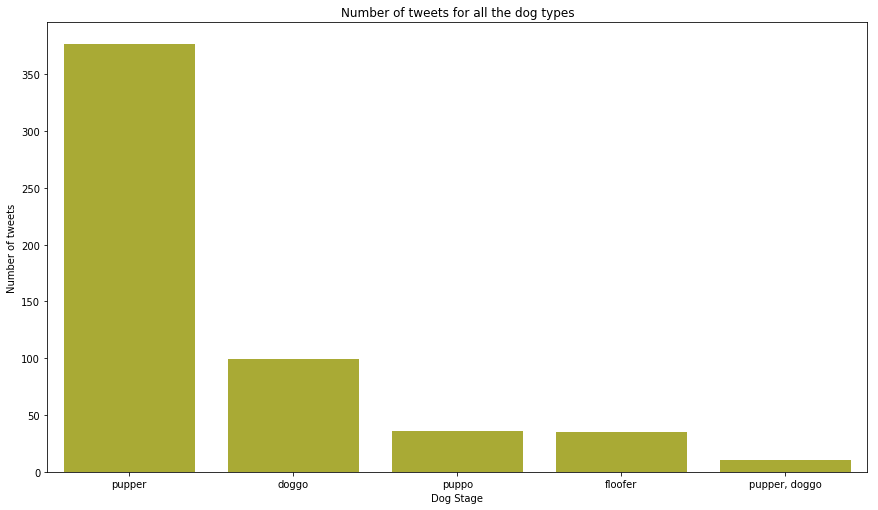

In [1094]:
# Number of tweets across all 4 dog types
plt.figure(figsize=[14.70, 8.27]);
base_color = sb.color_palette()[8];
sb.countplot(data=master_df, x='dog_stage', color=base_color);
plt.title('Number of tweets for all the dog types');
plt.xlabel('Dog Stage');
plt.ylabel('Number of tweets');

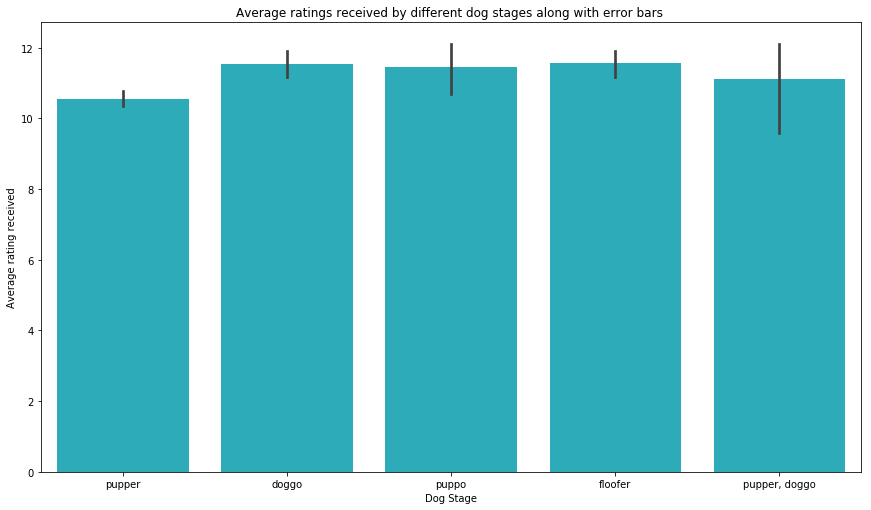

In [1095]:
# Avg. ratings received by different dog stage along with error bars 
plt.figure(figsize=[14.70, 8.27]);
base_color = sb.color_palette()[9];

sb.barplot(data=master_df, x='dog_stage', y='rating_numerator', color=base_color);
plt.title('Average ratings received by different dog stages along with error bars ');
plt.xlabel('Dog Stage');
plt.ylabel('Average rating received');

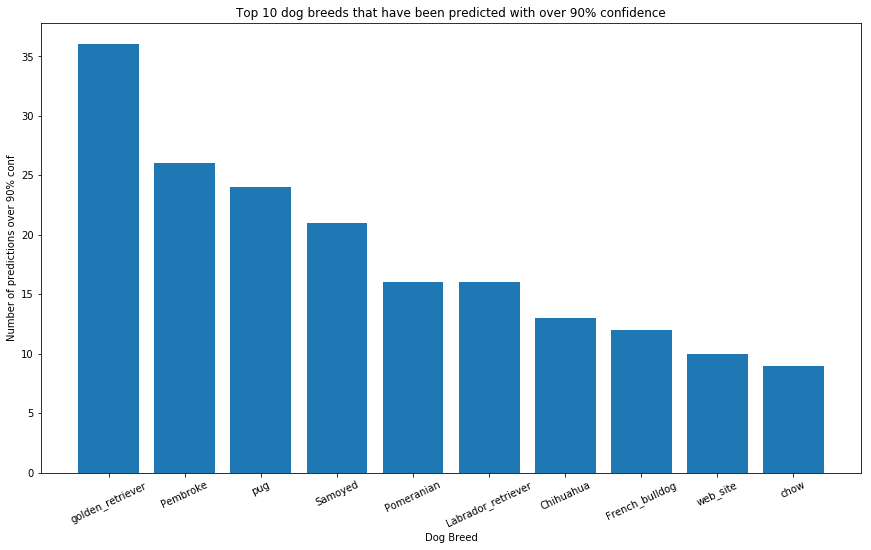

In [1096]:
# Top 10 dog breeds that have been predicted with over 90% confidence
dog_conf90 = master_df.query('pred_confidence>0.90')['dog_prediction'].value_counts()\
            .rename('count').reset_index().head(10)
dog_conf90.rename(columns={'index':'dog_prediction'}, inplace=True)

plt.figure(figsize=[14.70, 8.27]);
base_color = sb.color_palette()[9];
plt.bar(data=dog_conf90, x='dog_prediction', height='count');
plt.title('Top 10 dog breeds that have been predicted with over 90% confidence');
plt.xticks(rotation=25);
plt.xlabel('Dog Breed');
plt.ylabel('Number of predictions over 90% conf');

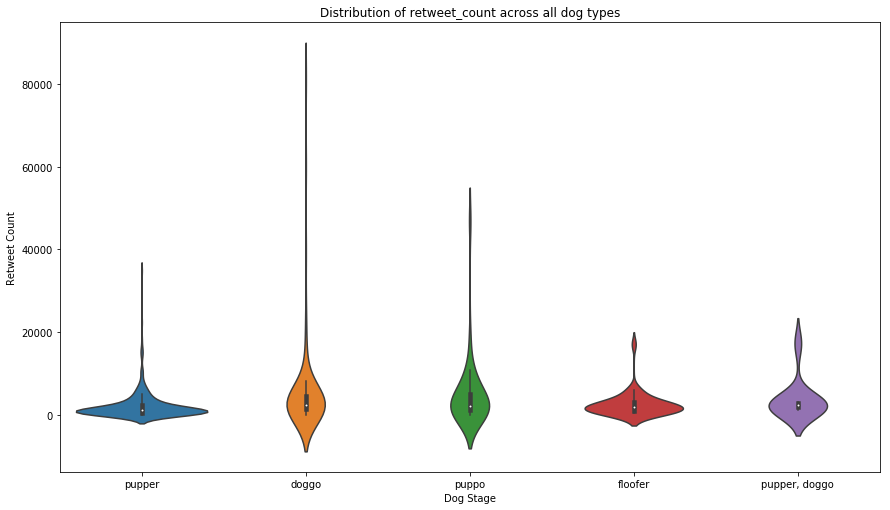

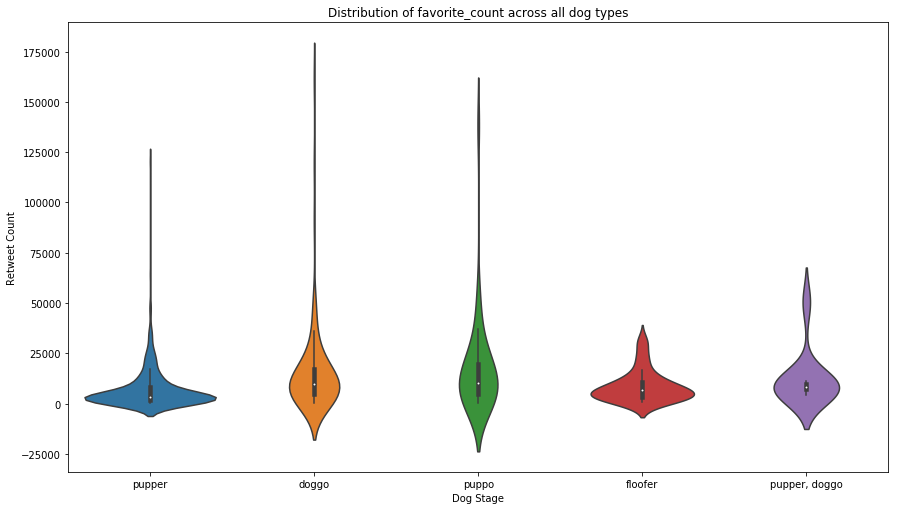

In [1097]:
# Distribution of retweet and favorite count across all dog stages
visual_list = ['retweet_count', 'favorite_count']

for i in visual_list:
    plt.figure(figsize=[14.70, 8.27]);
    sb.violinplot(data=master_df, x='dog_stage', y=i);
    plt.title('Distribution of '+ i+' across all dog types');
    plt.xlabel('Dog Stage');
    plt.ylabel('Retweet Count');
    plt.show();

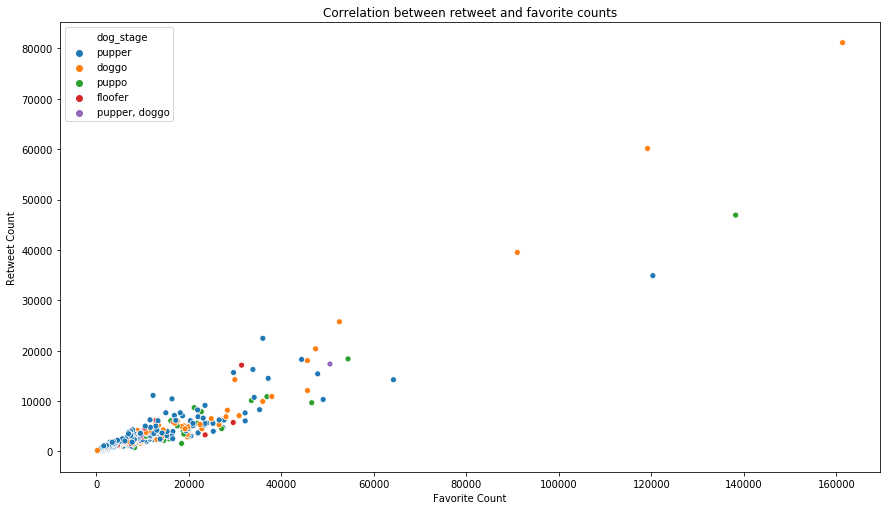

In [1098]:
# Check the correlation between retweet and favorite count shows highly positive correlation
plt.figure(figsize=[14.70, 8.27]);
sb.scatterplot(data=master_df, x='favorite_count', y='retweet_count', hue='dog_stage');

plt.title('Correlation between retweet and favorite counts');
plt.xlabel('Favorite Count');
plt.ylabel('Retweet Count');

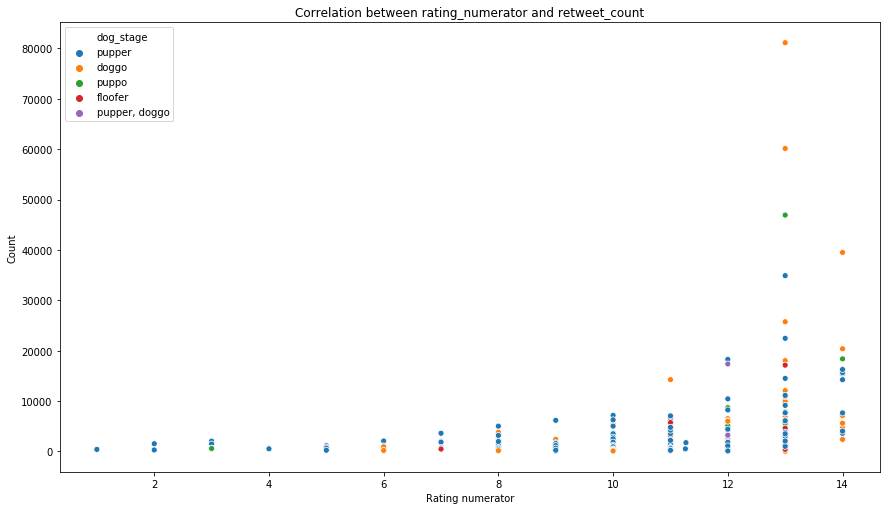

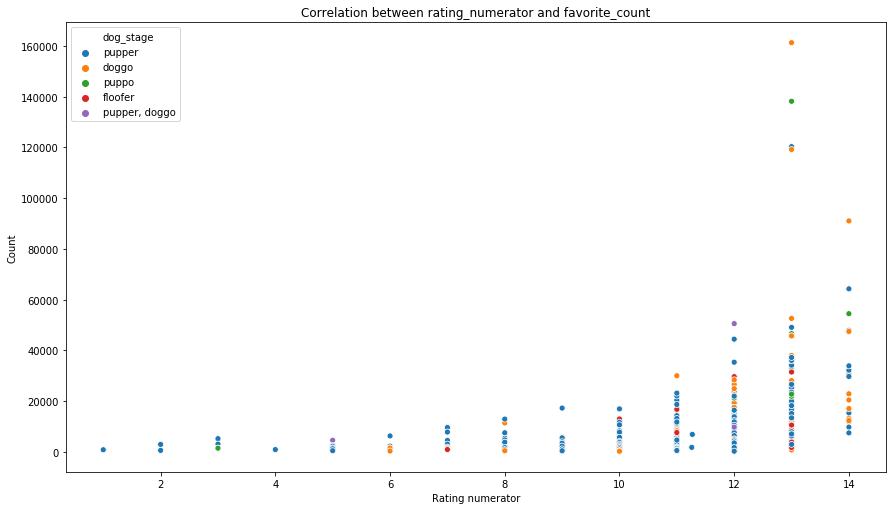

In [1099]:
# Check the correlation between rating and retweet/favorite count
visual_list = ['retweet_count', 'favorite_count']

for i in visual_list:
    plt.figure(figsize=[14.70, 8.27]);
    sb.scatterplot(data=master_df, x='rating_numerator', y=i, hue='dog_stage');
    plt.title('Correlation between rating_numerator and '+ i);
    plt.xlabel('Rating numerator');
    plt.ylabel('Count');
    
    plt.show()

## Key Insights

- Doggo, puppo, and floofer on an average have recieved a very similar rating between 11.5 and 12 with puppo having a relatively higher error margin. Pupper on the other hand have a slightly lower average rating ~10.5. 'pupper, doggo' has an average rating ~11 but with a very high error margin.
- 'Golden Retriver', 'Pembroke', 'Pug' are the top 3 dog breeds that have been predicted with over 90% confidence.
- When compared for the maximum number of retweets and favorites, all 4 dog stages have a similar median except pupper with a slightly lower median. doggo has few extremely high values (outliers) for both retweet and favorite counts that pulls the distribution higher than the rest followed closely being followed by puppo.
- A very high correlation is seen between the number of retweet and the number of favorite tweets. From the scatter plot, it is observed that majority of the tweets have been favoritized twice as much as they were retweeted.
- A very clear correlation is seen between ratings and the count of retweet/favorite tweets i.e higher the rating, higher is the number of retweets/favorites with maximized counts at rating 13.

## References
http://docs.tweepy.org/en/v3.5.0/api.html <br>
https://stackoverflow.com/questions/11174024/attributeerrorstr-object-has-no-attribute-read <br>
https://stackabuse.com/reading-and-writing-json-to-a-file-in-python/ <br>
https://stackoverflow.com/questions/34379168/how-to-save-the-tweets-in-json-to-txt-file-in-python-3-4 <br>
https://stackoverflow.com/questions/21287624/convert-pandas-column-containing-nans-to-dtype-int <br>
https://stackoverflow.com/questions/18648626/for-loop-with-two-variables <br>
https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html <br>
https://stackoverflow.com/questions/17978133/python-pandas-merge-only-certain-columns <br>
https://stackoverflow.com/questions/15315452/selecting-with-complex-criteria-from-pandas-dataframe <br>
https://stackoverflow.com/questions/36743563/preserve-dataframe-column-data-type-after-outer-merge <br>
https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-data-frame <br>